In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, Conv2D,MaxPooling2D, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
# 1. 데이터 로드 및 전처리
# 1. 데이터 로드 및 전처리
#data = pd.read_csv('training_data.csv')  # CSV 파일을 로드합니다
data = pd.read_csv('train_nodiff_combined_magnitude.csv')  # CSV 파일을 로드합니다
X_train_all = data.iloc[:, 1:81].values
Y_train_all = data.iloc[:, 0].values

# test_data = pd.read_csv('test_data_with_D,RSSI,CIR.csv')
#test_data = pd.read_csv('Setting_2/combined_test_data.csv')
test_data = pd.read_csv('test_nodiff_combined_magnitude.csv')
X_test_all= test_data.iloc[:, 1:81].values
Y_test_all = test_data.iloc[:, 0].values


# Transform labels: 10, 11 -> 0; 12, 13 -> 1
def transform_labels(Y):
    Y_transformed = np.where((Y == 10) | (Y == 11), 0, np.where((Y == 12) | (Y == 13), 1, -1))
    return Y_transformed

Y_train_all_transformed = transform_labels(Y_train_all)
Y_test_all_transformed = transform_labels(Y_test_all)

# Ensure there are no invalid labels after transformation
assert np.all(Y_train_all_transformed != -1)
assert np.all(Y_test_all_transformed != -1)

unique_y = np.unique(Y_train_all_transformed)
num_classes = len(unique_y)

# Y 값에 따라 데이터를 그룹화하여 학습 데이터와 테스트 데이터를 분리합니다
# unique_y = np.unique(Y_train_all)
# num_classes = len(unique_y)
# y_mapping = {y: idx for idx, y in enumerate(unique_y)}
# Y_train_all = np.array([y_mapping[y] for y in Y_train_all])
# Y_test_all = np.array([y_mapping[y] for y in Y_test_all])

In [34]:
# Set window size (n) and number of samples per chunk (m)
window_size = 430
num_samples_per_chunk = 30
#순서 영향, 한 번에 다 학습?(1000개)
def sample_chunks_balanced(X, Y, window_size, num_samples_per_chunk):
    X_samples = []
    Y_samples = []
    unique_y = np.unique(Y)
    for y in unique_y:
        y_indices = np.where(Y == y)[0]
        num_chunks = len(y_indices) // 1000
        for i in range(num_chunks):
            chunk_indices = y_indices[i * 1000:(i + 1) * 1000]
            for _ in range(num_samples_per_chunk):
                start_idx = np.random.choice(chunk_indices[:-window_size + 1], 1)[0]
                X_samples.append(X[start_idx:start_idx + window_size])
                Y_samples.append(y)
    return np.array(X_samples), np.array(Y_samples)

# Create balanced training and testing samples
X_train, Y_train = sample_chunks_balanced(X_train_all, Y_train_all_transformed, window_size, num_samples_per_chunk)
X_test, Y_test = sample_chunks_balanced(X_test_all, Y_test_all_transformed, window_size, num_samples_per_chunk)


# Split the selected data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Convert Y values to categorical
Y_train = to_categorical(Y_train, num_classes=2)
Y_val = to_categorical(Y_val, num_classes=2)
Y_test = to_categorical(Y_test, num_classes=2)

# Reshape the data for model input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]


In [35]:
# 파라미터 조합 정의

epochs_list = [50, 100, 150]
learning_rates = [0.001, 0.0001]
optimizers = [Adam, SGD]
dropout_rates = [0.3, 0.5]
dense_units = [64, 128]
conv_filters = [32, 64]

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8210 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32
Model and parameters saved: model_0.82_epochs50_lr0.001_optAdam_dropout0.3_dense64_conv32.h5, params_0.82_epochs50_lr0.001_optAdam_dropout0.3_dense64_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3208, Accuracy = 0.6792
Class 1: Error Rate = 0.0810, Accuracy = 0.9190


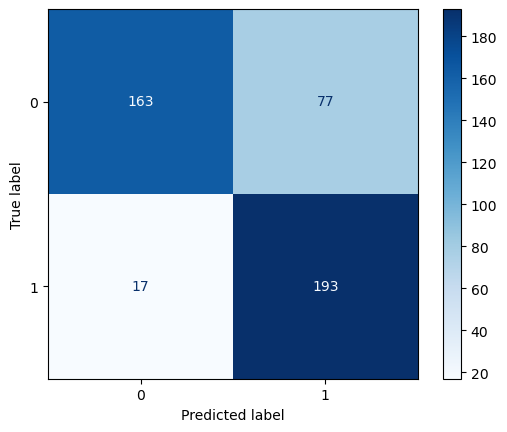

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.8642 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.86_epochs50_lr0.001_optAdam_dropout0.3_dense64_conv64.h5, params_0.86_epochs50_lr0.001_optAdam_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.1583, Accuracy = 0.8417
Class 1: Error Rate = 0.4476, Accuracy = 0.5524


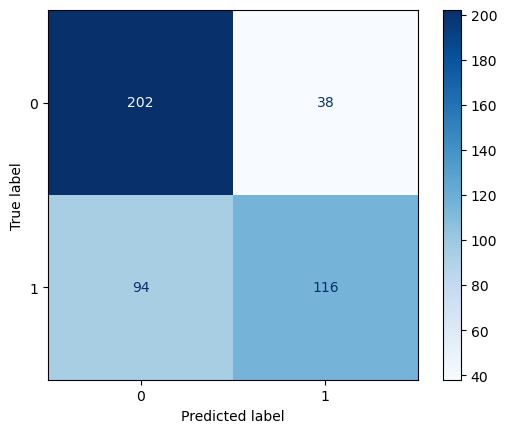

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7037 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8457 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.85_epochs50_lr0.001_optAdam_dropout0.3_dense128_conv64.h5, params_0.85_epochs50_lr0.001_optAdam_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2625, Accuracy = 0.7375
Class 1: Error Rate = 0.2857, Accuracy = 0.7143


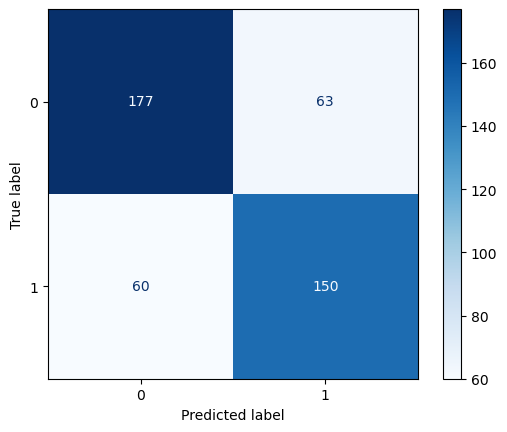

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6914 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8580 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64
Model and parameters saved: model_0.86_epochs50_lr0.001_optAdam_dropout0.5_dense64_conv64.h5, params_0.86_epochs50_lr0.001_optAdam_dropout0.5_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2542, Accuracy = 0.7458
Class 1: Error Rate = 0.3238, Accuracy = 0.6762


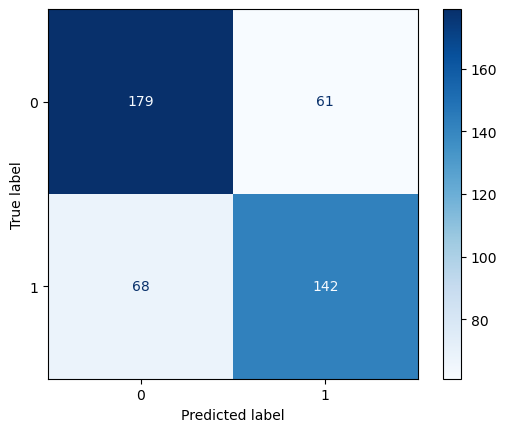

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9012 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32
Model and parameters saved: model_0.90_epochs50_lr0.001_optAdam_dropout0.5_dense128_conv32.h5, params_0.90_epochs50_lr0.001_optAdam_dropout0.5_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3083, Accuracy = 0.6917
Class 1: Error Rate = 0.2238, Accuracy = 0.7762


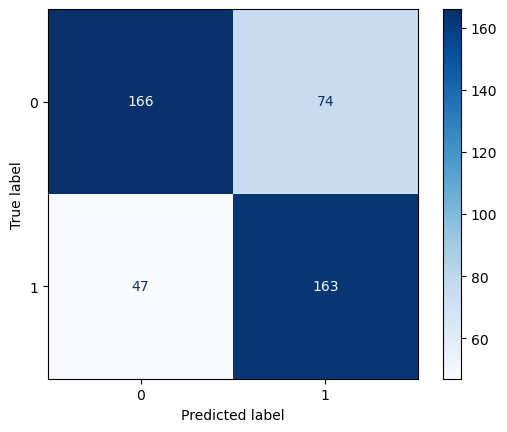

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7778 with parameters: epochs=50, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6358 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.5000 with parameters: epochs=50, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.6235 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8333 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.83_epochs50_lr0.0001_optAdam_dropout0.3_dense64_conv64.h5, params_0.83_epochs50_lr0.0001_optAdam_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2583, Accuracy = 0.7417
Class 1: Error Rate = 0.4238, Accuracy = 0.5762


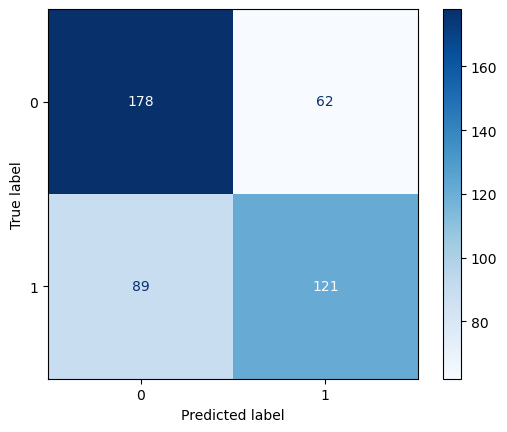

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7469 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.3642 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.3210 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0494 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7407 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7963 with parameters: epochs=50, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6852 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.6790 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5679 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8272 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.83_epochs50_lr0.0001_optSGD_dropout0.3_dense128_conv64.h5, params_0.83_epochs50_lr0.0001_optSGD_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2458, Accuracy = 0.7542
Class 1: Error Rate = 0.3238, Accuracy = 0.6762


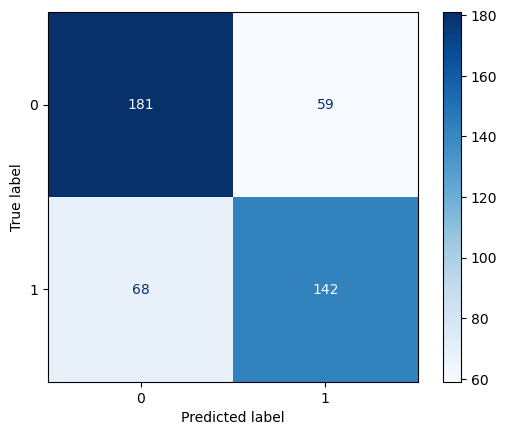

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.1728 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7346 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6914 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9198 with parameters: epochs=50, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64
Model and parameters saved: model_0.92_epochs50_lr0.0001_optSGD_dropout0.5_dense128_conv64.h5, params_0.92_epochs50_lr0.0001_optSGD_dropout0.5_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3292, Accuracy = 0.6708
Class 1: Error Rate = 0.3619, Accuracy = 0.6381


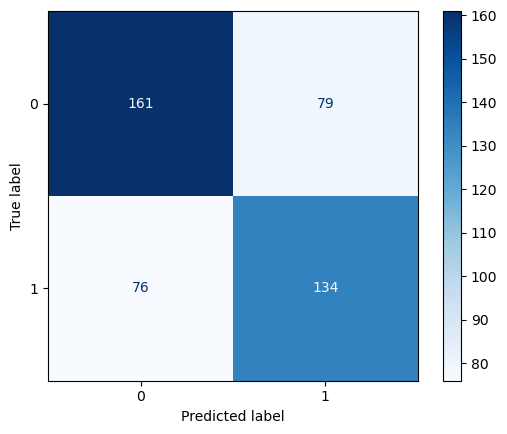

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6852 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.8827 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.88_epochs100_lr0.001_optAdam_dropout0.3_dense64_conv64.h5, params_0.88_epochs100_lr0.001_optAdam_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2833, Accuracy = 0.7167
Class 1: Error Rate = 0.2667, Accuracy = 0.7333


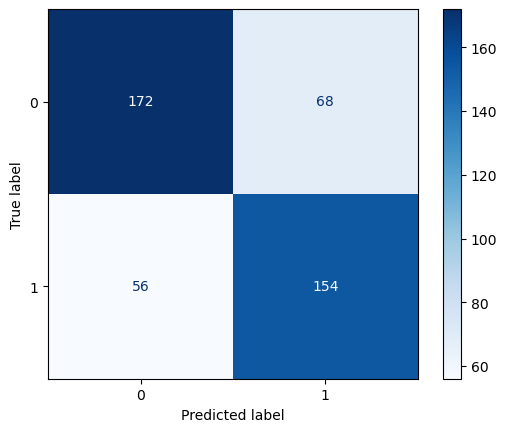

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8642 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32
Model and parameters saved: model_0.86_epochs100_lr0.001_optAdam_dropout0.3_dense128_conv32.h5, params_0.86_epochs100_lr0.001_optAdam_dropout0.3_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Class 0: Error Rate = 0.2125, Accuracy = 0.7875
Class 1: Error Rate = 0.4143, Accuracy = 0.5857


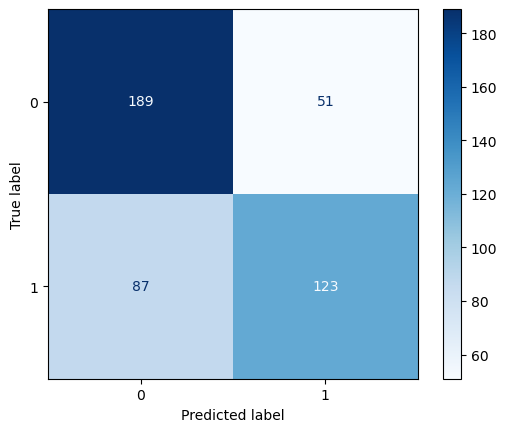

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.9630 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.96_epochs100_lr0.001_optAdam_dropout0.3_dense128_conv64.h5, params_0.96_epochs100_lr0.001_optAdam_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Class 0: Error Rate = 0.2667, Accuracy = 0.7333
Class 1: Error Rate = 0.5190, Accuracy = 0.4810


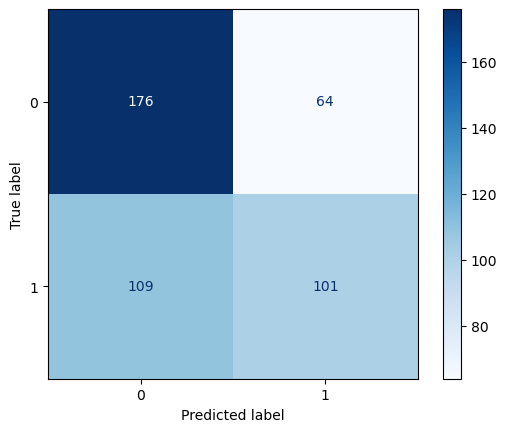

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9136 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32
Model and parameters saved: model_0.91_epochs100_lr0.001_optAdam_dropout0.5_dense64_conv32.h5, params_0.91_epochs100_lr0.001_optAdam_dropout0.5_dense64_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Class 0: Error Rate = 0.2375, Accuracy = 0.7625
Class 1: Error Rate = 0.3429, Accuracy = 0.6571


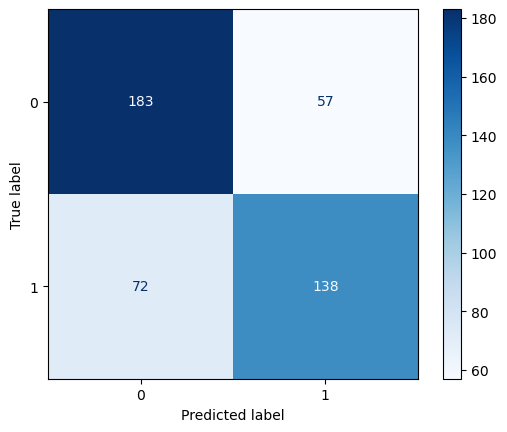

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8580 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64
Model and parameters saved: model_0.86_epochs100_lr0.001_optAdam_dropout0.5_dense64_conv64.h5, params_0.86_epochs100_lr0.001_optAdam_dropout0.5_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.1958, Accuracy = 0.8042
Class 1: Error Rate = 0.4143, Accuracy = 0.5857


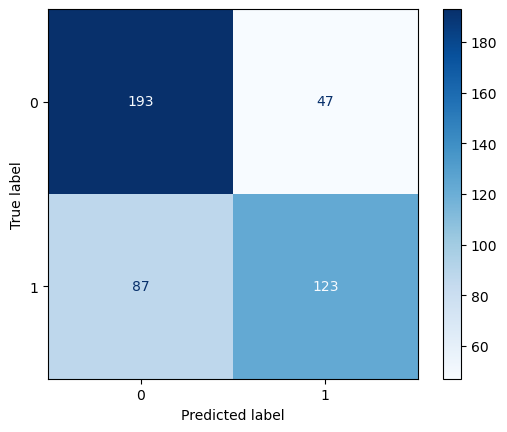

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8210 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32
Model and parameters saved: model_0.82_epochs100_lr0.001_optAdam_dropout0.5_dense128_conv32.h5, params_0.82_epochs100_lr0.001_optAdam_dropout0.5_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3958, Accuracy = 0.6042
Class 1: Error Rate = 0.1714, Accuracy = 0.8286


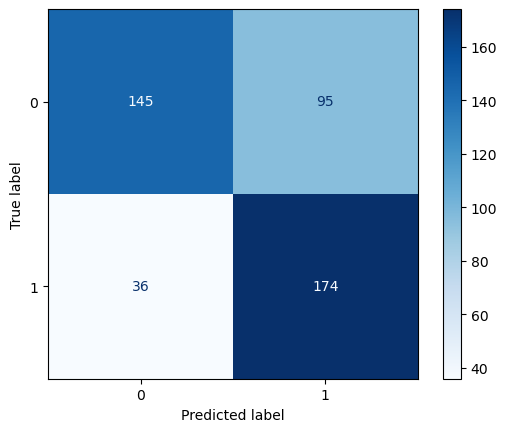

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.8889 with parameters: epochs=100, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64
Model and parameters saved: model_0.89_epochs100_lr0.001_optAdam_dropout0.5_dense128_conv64.h5, params_0.89_epochs100_lr0.001_optAdam_dropout0.5_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3125, Accuracy = 0.6875
Class 1: Error Rate = 0.3619, Accuracy = 0.6381


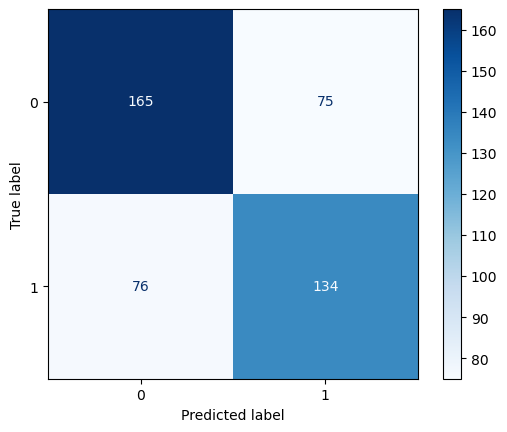

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5370 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8025 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32
Model and parameters saved: model_0.80_epochs100_lr0.001_optSGD_dropout0.3_dense128_conv32.h5, params_0.80_epochs100_lr0.001_optSGD_dropout0.3_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3333, Accuracy = 0.6667
Class 1: Error Rate = 0.2857, Accuracy = 0.7143


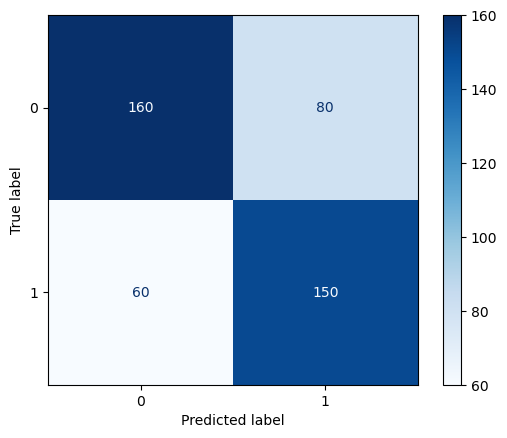

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.0000 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5123 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0679 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.5000 with parameters: epochs=100, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5679 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.8025 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.80_epochs100_lr0.0001_optAdam_dropout0.3_dense64_conv64.h5, params_0.80_epochs100_lr0.0001_optAdam_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.0292, Accuracy = 0.9708
Class 1: Error Rate = 0.5333, Accuracy = 0.4667


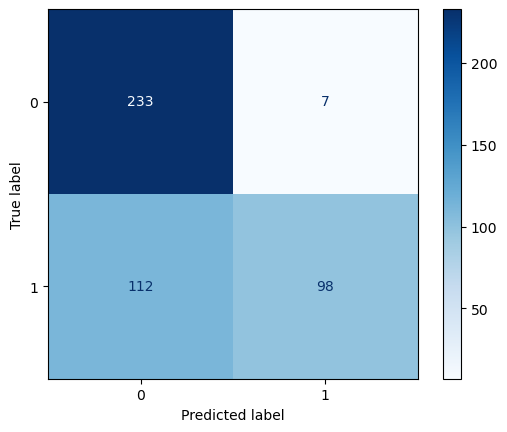

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7407 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7901 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7099 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8457 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64
Model and parameters saved: model_0.85_epochs100_lr0.0001_optAdam_dropout0.5_dense64_conv64.h5, params_0.85_epochs100_lr0.0001_optAdam_dropout0.5_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2375, Accuracy = 0.7625
Class 1: Error Rate = 0.2381, Accuracy = 0.7619


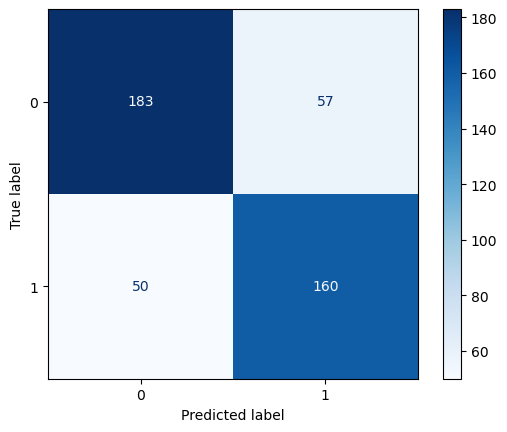

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5617 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.5988 with parameters: epochs=100, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.4815 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6975 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7531 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.9136 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.91_epochs100_lr0.0001_optSGD_dropout0.3_dense128_conv64.h5, params_0.91_epochs100_lr0.0001_optSGD_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3875, Accuracy = 0.6125
Class 1: Error Rate = 0.3810, Accuracy = 0.6190


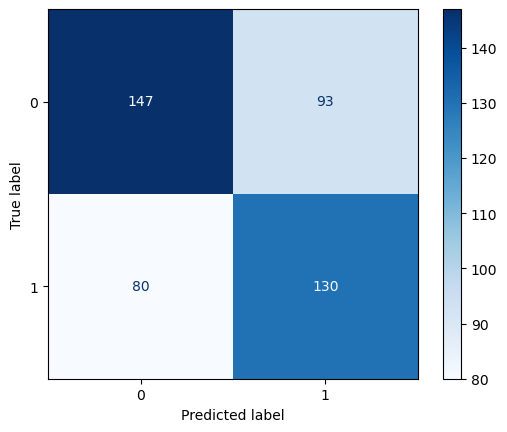

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5123 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8210 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64
Model and parameters saved: model_0.82_epochs100_lr0.0001_optSGD_dropout0.5_dense64_conv64.h5, params_0.82_epochs100_lr0.0001_optSGD_dropout0.5_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2125, Accuracy = 0.7875
Class 1: Error Rate = 0.2952, Accuracy = 0.7048


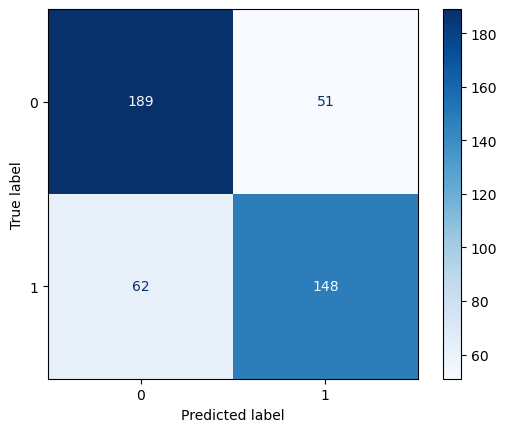

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7222 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9012 with parameters: epochs=100, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64
Model and parameters saved: model_0.90_epochs100_lr0.0001_optSGD_dropout0.5_dense128_conv64.h5, params_0.90_epochs100_lr0.0001_optSGD_dropout0.5_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.4250, Accuracy = 0.5750
Class 1: Error Rate = 0.2286, Accuracy = 0.7714


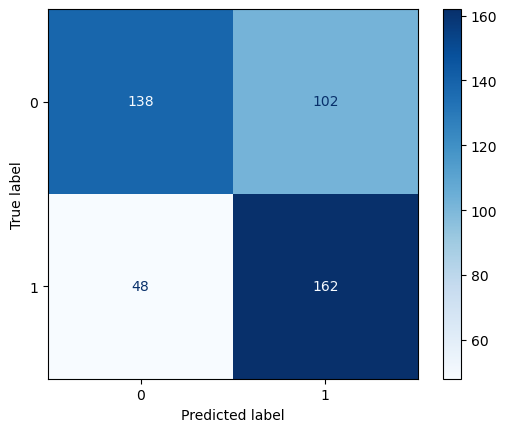

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Accuracy: 0.9012 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32
Model and parameters saved: model_0.90_epochs150_lr0.001_optAdam_dropout0.3_dense64_conv32.h5, params_0.90_epochs150_lr0.001_optAdam_dropout0.3_dense64_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.1083, Accuracy = 0.8917
Class 1: Error Rate = 0.5952, Accuracy = 0.4048


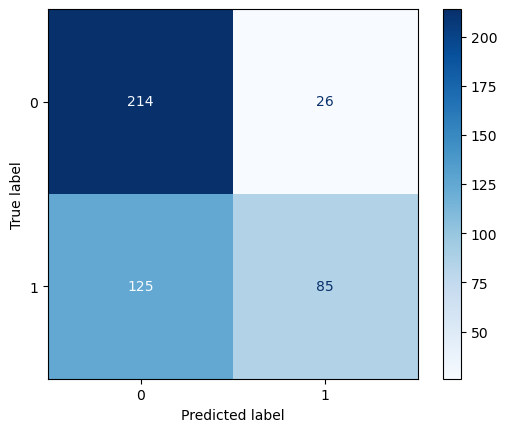

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9198 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.92_epochs150_lr0.001_optAdam_dropout0.3_dense64_conv64.h5, params_0.92_epochs150_lr0.001_optAdam_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.4708, Accuracy = 0.5292
Class 1: Error Rate = 0.3619, Accuracy = 0.6381


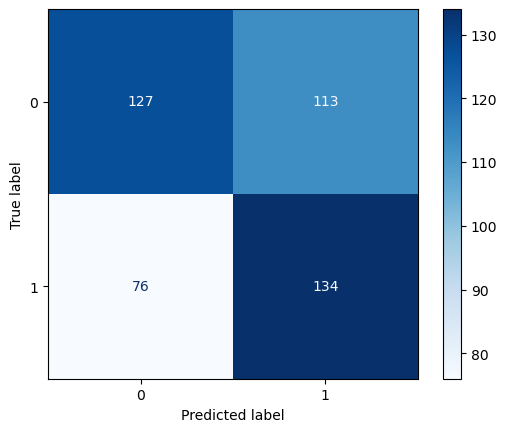

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8580 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32
Model and parameters saved: model_0.86_epochs150_lr0.001_optAdam_dropout0.3_dense128_conv32.h5, params_0.86_epochs150_lr0.001_optAdam_dropout0.3_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2000, Accuracy = 0.8000
Class 1: Error Rate = 0.3619, Accuracy = 0.6381


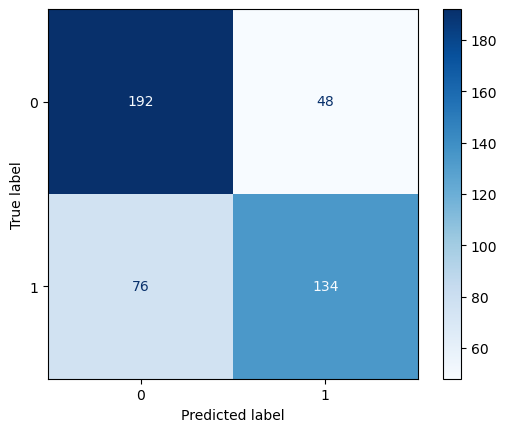

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9136 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.91_epochs150_lr0.001_optAdam_dropout0.3_dense128_conv64.h5, params_0.91_epochs150_lr0.001_optAdam_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.1417, Accuracy = 0.8583
Class 1: Error Rate = 0.2048, Accuracy = 0.7952


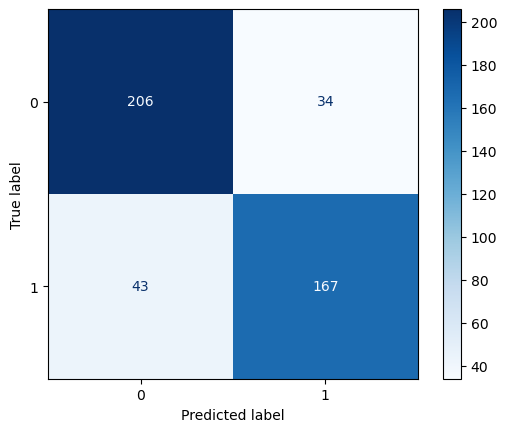

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Accuracy: 0.9136 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32
Model and parameters saved: model_0.91_epochs150_lr0.001_optAdam_dropout0.5_dense64_conv32.h5, params_0.91_epochs150_lr0.001_optAdam_dropout0.5_dense64_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3083, Accuracy = 0.6917
Class 1: Error Rate = 0.5238, Accuracy = 0.4762


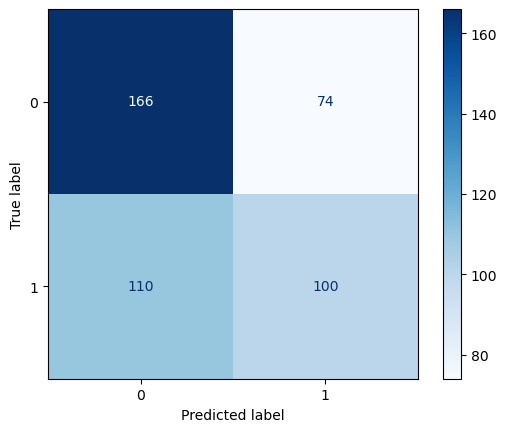

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6481 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8704 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32
Model and parameters saved: model_0.87_epochs150_lr0.001_optAdam_dropout0.5_dense128_conv32.h5, params_0.87_epochs150_lr0.001_optAdam_dropout0.5_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.1250, Accuracy = 0.8750
Class 1: Error Rate = 0.1048, Accuracy = 0.8952


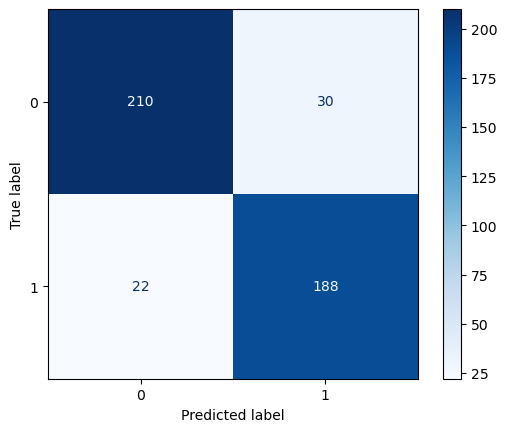

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7593 with parameters: epochs=150, learning_rate=0.001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0185 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6667 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0000 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5000 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Accuracy: 0.0370 with parameters: epochs=150, learning_rate=0.001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.6049 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5370 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.2222 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6235 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.3, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6975 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.5556 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7407 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.0062 with parameters: epochs=150, learning_rate=0.0001, optimizer=Adam, dropout_rate=0.5, dense_units=128, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6358 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8333 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=64, conv_filters=64
Model and parameters saved: model_0.83_epochs150_lr0.0001_optSGD_dropout0.3_dense64_conv64.h5, params_0.83_epochs150_lr0.0001_optSGD_dropout0.3_dense64_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.4875, Accuracy = 0.5125
Class 1: Error Rate = 0.1571, Accuracy = 0.8429


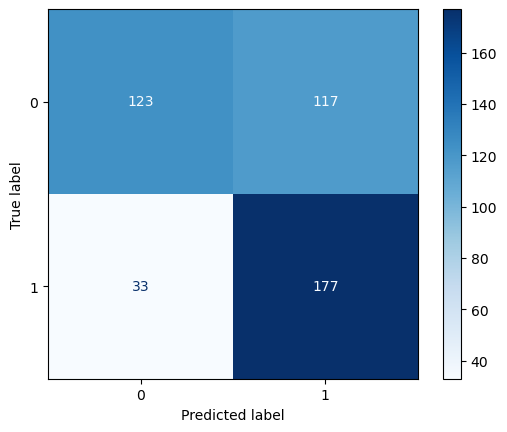

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8395 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=32
Model and parameters saved: model_0.84_epochs150_lr0.0001_optSGD_dropout0.3_dense128_conv32.h5, params_0.84_epochs150_lr0.0001_optSGD_dropout0.3_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.3583, Accuracy = 0.6417
Class 1: Error Rate = 0.2286, Accuracy = 0.7714


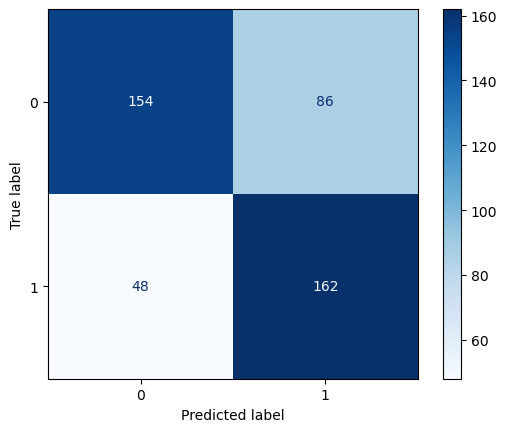

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8519 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.3, dense_units=128, conv_filters=64
Model and parameters saved: model_0.85_epochs150_lr0.0001_optSGD_dropout0.3_dense128_conv64.h5, params_0.85_epochs150_lr0.0001_optSGD_dropout0.3_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Class 0: Error Rate = 0.2250, Accuracy = 0.7750
Class 1: Error Rate = 0.4286, Accuracy = 0.5714


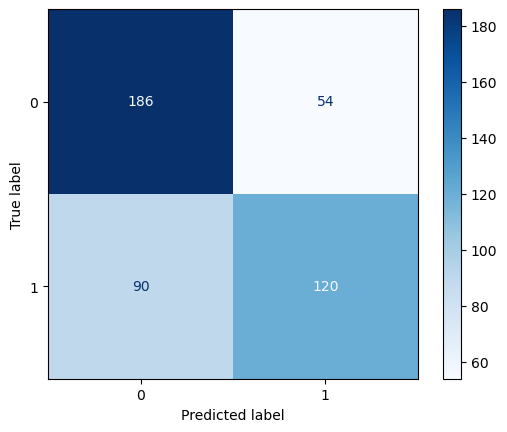

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.6790 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=32


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Accuracy: 0.7284 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=64, conv_filters=64


C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.9321 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=32
Model and parameters saved: model_0.93_epochs150_lr0.0001_optSGD_dropout0.5_dense128_conv32.h5, params_0.93_epochs150_lr0.0001_optSGD_dropout0.5_dense128_conv32.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.4125, Accuracy = 0.5875
Class 1: Error Rate = 0.8095, Accuracy = 0.1905


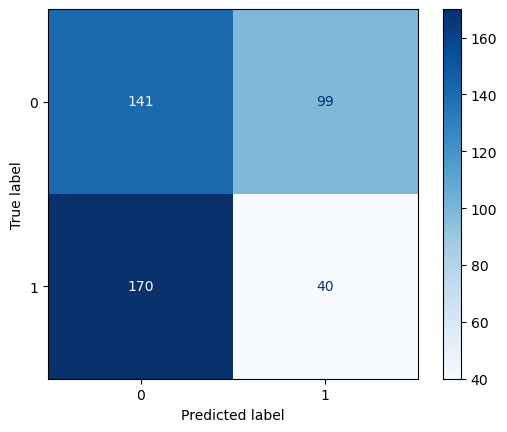

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Accuracy: 0.8519 with parameters: epochs=150, learning_rate=0.0001, optimizer=SGD, dropout_rate=0.5, dense_units=128, conv_filters=64
Model and parameters saved: model_0.85_epochs150_lr0.0001_optSGD_dropout0.5_dense128_conv64.h5, params_0.85_epochs150_lr0.0001_optSGD_dropout0.5_dense128_conv64.pkl
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class 0: Error Rate = 0.2208, Accuracy = 0.7792
Class 1: Error Rate = 0.2048, Accuracy = 0.7952


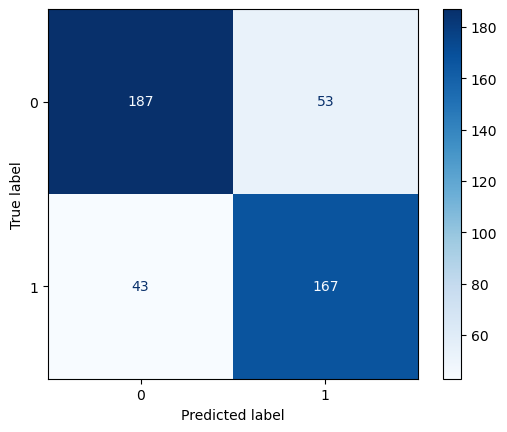

In [38]:
# 모든 조합에 대해 반복
for epochs, lr, optimizer, dropout_rate, dense_unit, conv_filter in itertools.product(
     epochs_list, learning_rates, optimizers, dropout_rates, dense_units, conv_filters):

    # 모델 정의
    model = Sequential([
        Conv1D(filters=conv_filter, kernel_size=3, activation='relu', input_shape=(window_size, X_train_all.shape[1])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(dense_unit, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='sigmoid')
    ])
    
    opt = optimizer(learning_rate=lr)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

    model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val),
              callbacks=[early_stopping, reduce_lr], verbose=0)

    # 검증 데이터에 대한 예측
    Y_pred = (model.predict(X_val) > 0.5).astype(int)
    accuracy = accuracy_score(Y_val, Y_pred)
    
    print(f'Accuracy: {accuracy:.4f} with parameters: '
          f'epochs={epochs}, learning_rate={lr}, optimizer={optimizer.__name__}, '
          f'dropout_rate={dropout_rate}, dense_units={dense_unit}, conv_filters={conv_filter}')
    
    # 정확도가 80% 이상인 경우 모델과 파라미터 저장
    if accuracy >= 0.8:
        model_name = f'model_{accuracy:.2f}_epochs{epochs}_lr{lr}_opt{optimizer.__name__}_dropout{dropout_rate}_dense{dense_unit}_conv{conv_filter}.h5'
        model.save(model_name)
        params = {
            'epochs': epochs,
            'learning_rate': lr,
            'optimizer': optimizer.__name__,
            'dropout_rate': dropout_rate,
            'dense_units': dense_unit,
            'conv_filters': conv_filter
        }
        params_name = f'params_{accuracy:.2f}_epochs{epochs}_lr{lr}_opt{optimizer.__name__}_dropout{dropout_rate}_dense{dense_unit}_conv{conv_filter}.pkl'
        joblib.dump(params, params_name)
        print(f'Model and parameters saved: {model_name}, {params_name}')

        Y_pred_samples = np.argmax(model.predict(X_test), axis=1)
        y_indices = np.argmax(Y_test, axis=1)

        error_rates = {}
        for y in np.unique(y_indices):
            y_selected = np.where(y_indices == y)
            y_true = y_indices[y_selected]
            y_pred = Y_pred_samples[y_selected]
            accuracy = np.mean(y_true == y_pred)
            error_rate = 1 - accuracy
            error_rates[y] = error_rate
            print(f'Class {y}: Error Rate = {error_rate:.4f}, Accuracy = {accuracy:.4f}')
        
        conf_matrix = confusion_matrix(y_indices, Y_pred_samples)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_y)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

In [1468]:
# model = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(window_size, X_train_all.shape[1], 1)),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.3),
#     Conv2D(64, kernel_size=(3, 3), activation='relu'),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(0.3),
#     Flatten(),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     Dense(num_classes, activation='softmax')
# ])


In [1469]:
# ### 3. CNN 모델 정의
# model = Sequential([
#     Flatten(input_shape=(window_size, X_train_all.shape[1])),
#     Dense(256, input_shape=(window_size, X_train_all.shape[1]), activation='relu'),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(num_classes, activation='sigmoid')
# ])

C:\Users\WIDEN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 0.6050 - loss: 0.6717 - val_accuracy: 0.7901 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - accuracy: 0.7956 - loss: 0.4676 - val_accuracy: 0.9136 - val_loss: 0.2339 - learning_rate: 0.0010
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.8953 - loss: 0.2539 - val_accuracy: 0.9136 - val_loss: 0.2093 - learning_rate: 0.0010
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9307 - loss: 0.1861 - val_accuracy: 0.9568 - val_loss: 0.1553 - learning_rate: 0.0010
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - accuracy: 0.9119 - loss: 0.2764 - val_accuracy: 0.6790 - val_loss: 0.6267 - learning_rate: 0.0010
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.6830 - loss: 0.5731 - val_accuracy: 0.7901 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.8055 - loss: 0.4448 - 

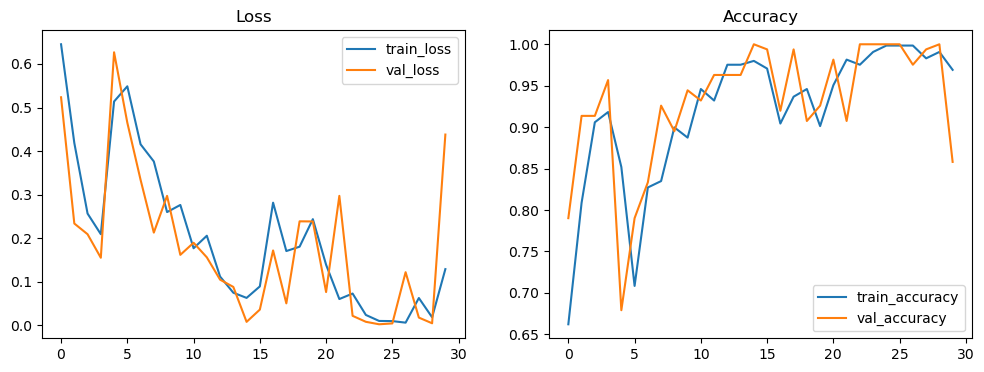

In [1477]:
## 5. 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

In [1478]:
# 6. 모델 저장
#model.save('new_trained_model_acc70_balanced_[430,40].h5')

In [1479]:
# 7. 예측 및 평가
loss, accuracy = model.evaluate(X_test, Y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

Y_pred_samples = np.argmax(model.predict(X_test), axis=1)
y_indices = np.argmax(Y_test, axis=1)

error_rates = {}
for y in np.unique(y_indices):
    y_selected = np.where(y_indices == y)
    y_true = y_indices[y_selected]
    y_pred = Y_pred_samples[y_selected]
    accuracy = np.mean(y_true == y_pred)
    error_rate = 1 - accuracy
    error_rates[y] = error_rate
    print(f'Class {y}: Error Rate = {error_rate:.4f}, Accuracy = {accuracy:.4f}')

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7482 - loss: 1.0468
Test Loss: 2.1381537914276123
Test Accuracy: 0.5444444417953491
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Class 0: Error Rate = 0.0667, Accuracy = 0.9333
Class 1: Error Rate = 0.9000, Accuracy = 0.1000


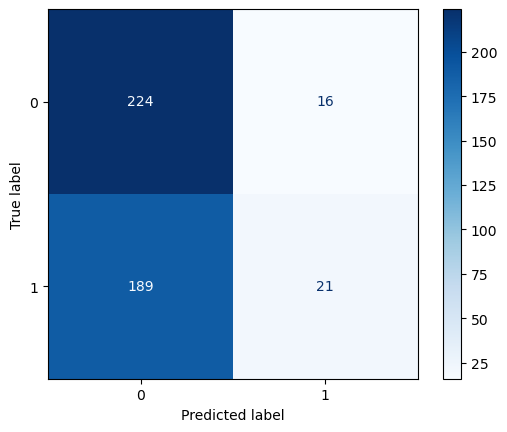

In [1480]:
conf_matrix = confusion_matrix(y_indices, Y_pred_samples)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=unique_y)
disp.plot(cmap=plt.cm.Blues)
plt.show()

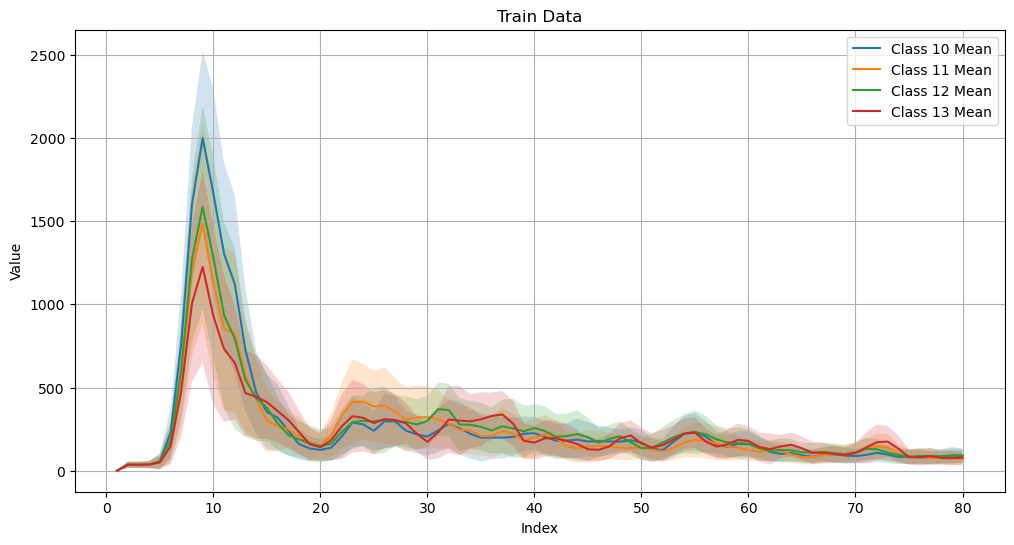

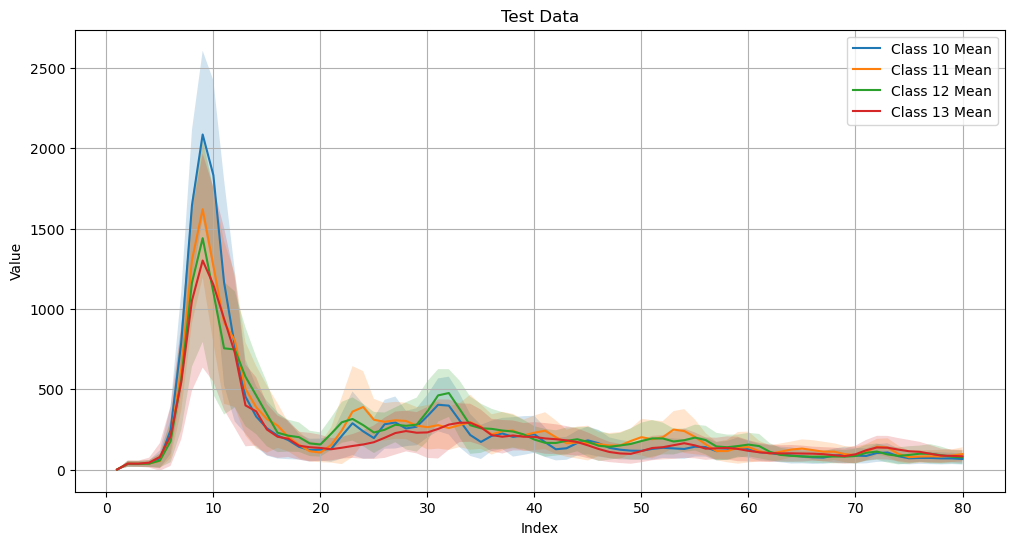

In [1380]:
import matplotlib.pyplot as plt

# 그래프 그리기
def plot_data(X, Y, title):
    unique_classes = np.unique(Y)
    plt.figure(figsize=(12, 6))
    
    for cls in unique_classes:
        indices = np.where(Y == cls)
        mean_values = X[indices].mean(axis=0)
        std_values = X[indices].std(axis=0)
        
        plt.plot(range(1, len(mean_values) + 1), mean_values, label=f'Class {cls} Mean')
        plt.fill_between(range(1, len(mean_values) + 1), mean_values - std_values, mean_values + std_values, alpha=0.2)
    
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 학습 데이터와 테스트 데이터 시각화
plot_data(X_train_all, Y_train_all, 'Train Data')
plot_data(X_test_all, Y_test_all, 'Test Data')
